# Setup

In [ ]:
pip install plottable

In [ ]:
pip install nltk

In [ ]:
pip install bertopic

In [ ]:
pip install topic-wizard

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image # image

from bertopic import BERTopic
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
kaggle = pd.read_json('/content/drive/My Drive/Colab Notebooks/4511/News_Category_Dataset_v3.json',lines=True)

# Kaggle Dataset

- DATA SOURCE: [click here](https://www.kaggle.com/datasets/rmisra/news-category-dataset?resource=download)
- DESCRIPTION:
    - Timeframe: 2012 to 2022 (11 years)
      - From 2012 to 2017, an average of 30,000 entries per year, around 2,000 entries per month
      - In 2018, approximately 8,000 entries for the year, with an average of 1,000 entries per month in the first half and around 100 entries per month in the second half
      - From 2019 to 2022, an average of 2,000 entries per year, approximately 150 entries per month on average
    - Source: HuffPost website
    - Data Volume: 210,000 entries (all non-null)
    - Fields: URL link, Title, Category, Short Description, Author, Time

### Basic Information

In [ ]:
kaggle.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
print("kaggle rows:",kaggle.shape[0])
print("kaggle columns:",kaggle.shape[1])

kaggle rows: 209527
kaggle columns: 6


In [ ]:
kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [ ]:
print("Number of unique Category:", kaggle['category'].nunique())

word_counts = kaggle['short_description'].str.split().apply(len)
average_word_count = word_counts.mean()
print("Average number of words in short description:", average_word_count)

Number of unique Category: 42
Average number of words in short description: 19.66902594892305


### Descriptive Analysis

#### Number of News by Year

In [ ]:
def numbers_of_news_by_year(df):
    # Extract the year information and calculate the number of news per year
    news_per_year = df['date'].dt.year.value_counts().sort_index()

    # Create a line plot
    plt.figure(figsize=(8, 4), dpi=110)
    plt.plot(news_per_year.index, news_per_year.values, marker='o', linestyle='-', color='#226E9C', linewidth=1.5)

    # Add numerical labels
    for i, (year, count) in enumerate(zip(news_per_year.index, news_per_year.values)):
        plt.text(year, count, str(count), ha='right', va='bottom')

    # Get the current axis object and set the visibility of the border lines
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add title and labels
    plt.xlabel('Year')
    plt.ylabel('Number of News')
    plt.title('Number of News per Year')

    # Show the plot
    plt.xticks(news_per_year.index)  # Set x-axis ticks to years
    plt.grid(True, color="lightgrey", ls=":")
    plt.tight_layout()
    plt.show()

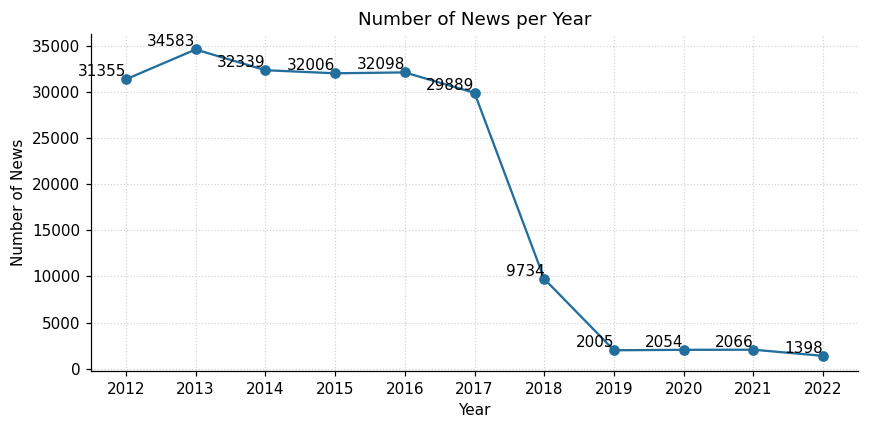

In [ ]:
numbers_of_news_by_year(kaggle)

#### Number of News by Month and Each Year

In [ ]:
# 提取年份和月份信息
kaggle['year'] = kaggle['date'].dt.year
kaggle['month'] = kaggle['date'].dt.month

# 计算每年每个月的新闻数量
news_per_month = kaggle.groupby(['year', 'month']).size().unstack().fillna(0)

# 计算每年的平均值和方差
mean_per_year = news_per_month.mean(axis=1).astype(int)
var_per_year = news_per_month.var(axis=1).astype(int)
stats_per_year = pd.DataFrame({'Mean': mean_per_year, 'Variance': var_per_year})

In [ ]:
def Number_of_news_by_month(news_per_month,stats_per_year):
    # 设置颜色映射
    cmap_first = LinearSegmentedColormap.from_list(
        name="custom_cmap",colors=["#E0FFFF","#BFEFFF", "#A4D3EE", "#6CA6CD", "#4F94CD","#226E9C"],N=5000)

    cmap_mean = LinearSegmentedColormap.from_list(
        name="cmap_mean", colors=["#E0FFFF","#BFEFFF", "#A4D3EE", "#6CA6CD", "#4F94CD","#226E9C"], N=5000)

    cmap_variance = LinearSegmentedColormap.from_list(
        name="cmap_variance", colors=["#FFF0F5", "#FFE4E1", "#FFE4E1", "#FFAEB9","#D8BFD8"], N=10000)

    mean_col_def = [
        ColumnDefinition(name="Mean",title="Mean",formatter=float,cmap=cmap_mean,border="left",)]
    variance_col_defs = [
        ColumnDefinition(name="Variance",title="Variance",formatter=float,cmap=cmap_variance,)]

    # 合并列定义
    col_defs = mean_col_def + variance_col_defs

    # 创建Figure和Axes对象
    fig, axs = plt.subplots(1, 2, figsize=(16, 6),gridspec_kw={'width_ratios': [1.5, 1]})

    # 创建热力图并添加到第一个Axes对象中
    heatmap = axs[0].imshow(news_per_month, cmap=cmap_first, aspect='auto')

    # 添加颜色条到第一个Axes对象中
    fig.colorbar(heatmap, ax=axs[0], label='Number of News')

    # 添加标签和标题到第一个Axes对象中
    axs[0].set_xlabel('Month')
    axs[0].set_ylabel('Year')
    axs[0].set_title('Number of News per Month')

    # 在每个方格中添加数值标签到第一个Axes对象中
    for i in range(len(news_per_month.index)):
        for j in range(len(news_per_month.columns)):
            axs[0].text(j, i, int(news_per_month.iloc[i, j]), ha='center', va='center', color='black')

    # 调整坐标轴刻度到第一个Axes对象中
    axs[0].set_xticks(range(12))
    axs[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axs[0].set_yticks(range(len(news_per_month.index)))
    axs[0].set_yticklabels(range(2012, 2023))

    # 创建表格并添加到第二个Axes对象中
    table = Table(
        stats_per_year,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=axs[1],
        textprops={"fontsize": 10,"ha": "center", "va": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"})

    axs[1].set_title('Month Mean and Variacne per Month')

    # 调整图形布局
    plt.tight_layout()

    # 显示图形
    plt.show()

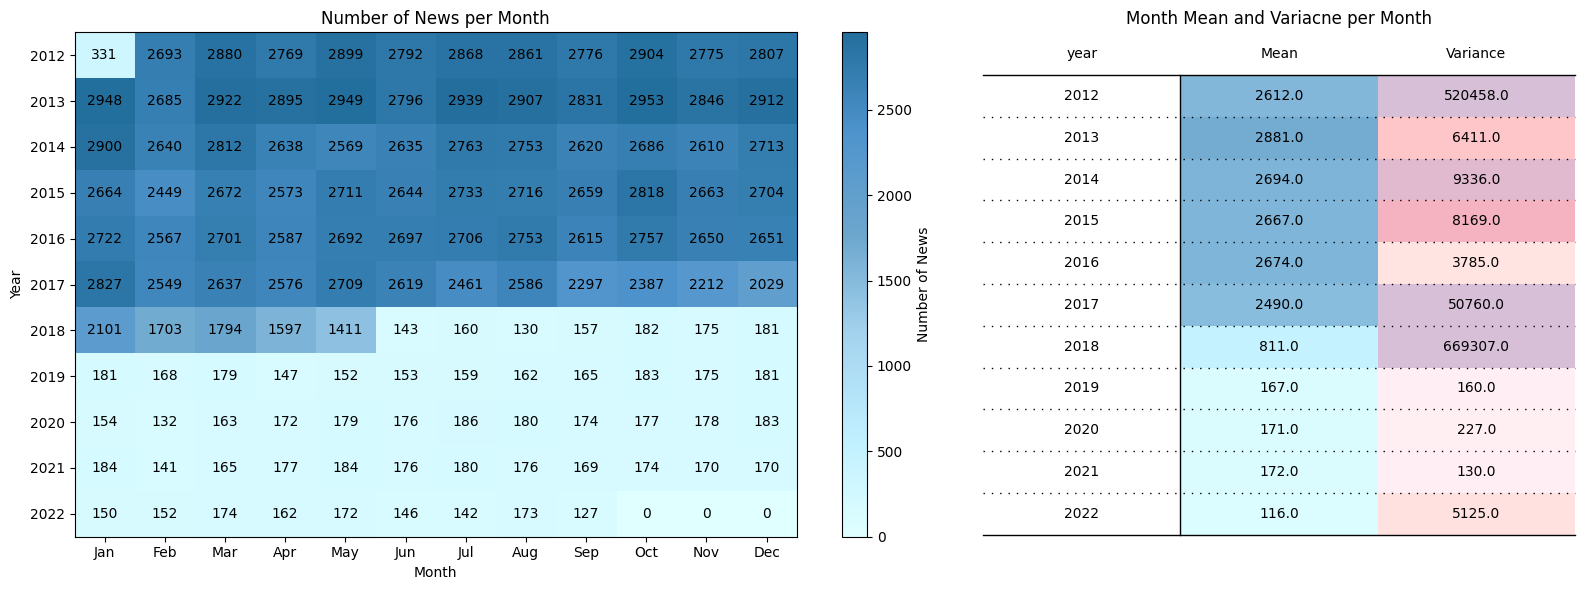

In [ ]:
Number_of_news_by_month(news_per_month,stats_per_year)


#### Number of News by Category

In [ ]:
def top_10_news(df):
    # 计算每个类别的出现次数
    category_counts = df['category'].value_counts()

    # 获取前十个类别和其出现次数
    top_ten_categories = category_counts.head(10)

    # 将数据分为前十个类别和其余类别
    top_ten_data = category_counts.loc[top_ten_categories.index]
    other_data = category_counts.loc[~category_counts.index.isin(top_ten_categories.index)]

    # 创建柱状图
    plt.figure(figsize=(10, 6), dpi=100)

    # 绘制前十个类别的柱状图
    bars = plt.bar(top_ten_data.index, top_ten_data.values, color='#226E9C', edgecolor='black', linewidth=0.75)

    # 绘制其余类别的柱状图，并用另一种颜色标记
    plt.bar(other_data.index, other_data.values, color='#BFEFFF', edgecolor='black', linewidth=0.75)

    # 获取当前的坐标轴对象并设置边框线的可见性
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # 添加标题和标签
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Count of Each Category in Kaggle Dataset')
    plt.grid(True, color="lightgrey", ls=":")

    # 旋转 x 轴标签以便显示
    plt.xticks(rotation='vertical')

    # 显示图形
    plt.tight_layout()
    plt.show()

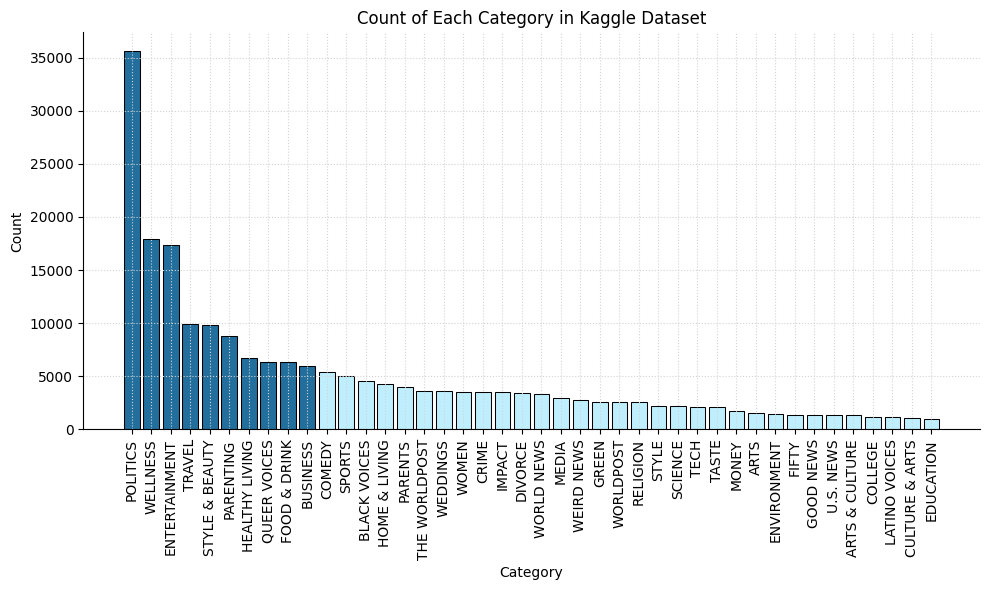

In [ ]:
top_10_news(kaggle)
## 前十是 政治，wellness，娱乐，旅行，时尚，健康生活，queer voices, 食物，business

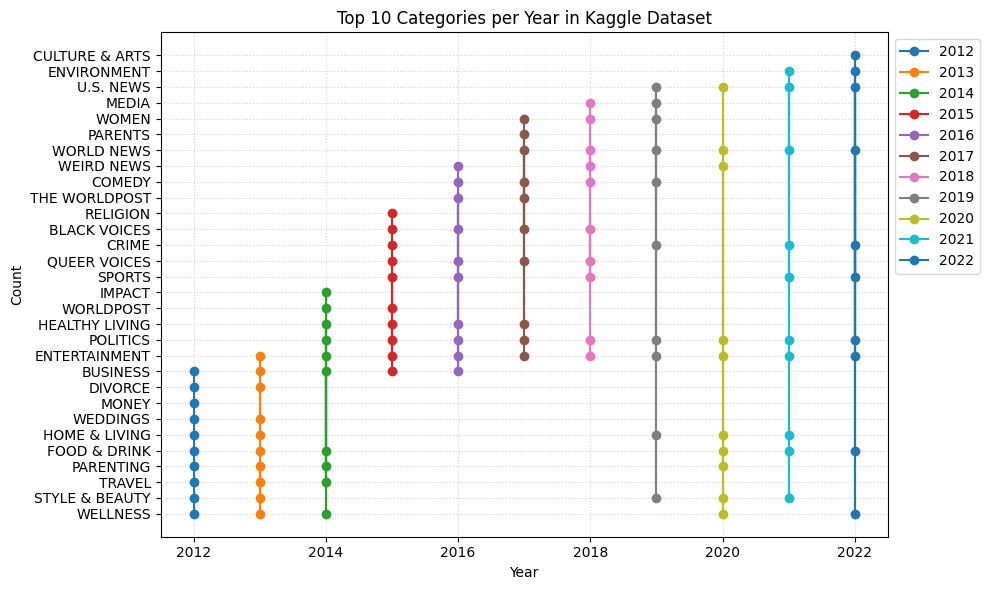

In [ ]:
## 每年前十变化

# 提取年份信息
kaggle['year'] = kaggle['date'].dt.year

# 计算每年每个新闻种类的数量
yearly_top_categories = kaggle.groupby(['year', 'category']).size().unstack().fillna(0)
yearly_top_categories_top10 = yearly_top_categories.apply(lambda x: x.nlargest(10).index.tolist(), axis=1)

# 创建折线图
plt.figure(figsize=(10, 6), dpi=100)

# 绘制每个年份前十个新闻种类的数量变化
for year in yearly_top_categories_top10.index:
    categories = yearly_top_categories_top10.loc[year]
    plt.plot([year] * len(categories), categories, marker='o', label=year)

# 添加标题和标签
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Top 10 Categories per Year in Kaggle Dataset')

# 添加图例
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 显示图形
plt.grid(True, color="lightgrey", ls=":")
plt.tight_layout()
plt.show()

# Bertopic Model

## first model-short_description

In [ ]:
docs = kaggle.loc[:20000,'short_description']
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,10198,-1_the_to_of_and,"[the, to, of, and, in, said, for, on, is, that]",[It's not what the president is reportedly tel...
1,0,716,0_you_im_me_my,"[you, im, me, my, it, we, like, this, just, dont]","[So you think you're really pretty?, ""Oh my Go..."
2,1,449,1_covid19_coronavirus_virus_pandemic,"[covid19, coronavirus, virus, pandemic, vaccin...",[Early cases of the virus were different from ...
3,2,421,2_this_nope_ouch_so,"[this, nope, ouch, so, here, go, you, it, its,...","[Nope nope nope nope nope nope nope., This is ..."
4,3,391,3_host_late_show_fox,"[host, late, show, fox, news, daily, tonight, ...","[The ""Late Show"" host takes on the vice presid..."
...,...,...,...,...,...
178,177,11,177_announcement_news_cnbc_unsurprising,"[announcement, news, cnbc, unsurprising, updat...",[An announcement on the decision will be made ...
179,178,10,178_vermont_progressive_de_blasio,"[vermont, progressive, de, blasio, senator, la...",[The backlash to Bill de Blasio and a sex scan...
180,179,10,179_sarah_lend_mckinnon_mutually,"[sarah, lend, mckinnon, mutually, globehopping...","[""Forgetting Sarah Marshall"" is just one of ma..."
181,180,10,180_mexico_57000_attest_amexican,"[mexico, 57000, attest, amexican, archipelago,...","[It was felt as far away as Las Vegas, and the..."


In [ ]:
topic_model.get_topic(2)

[('this', 0.02649361209959247),
 ('nope', 0.026322815799091483),
 ('ouch', 0.02572203916668031),
 ('so', 0.025078180209657082),
 ('here', 0.02142042282867477),
 ('go', 0.021416315370843615),
 ('you', 0.019645041998148604),
 ('it', 0.019499039329575453),
 ('its', 0.018605818350380353),
 ('we', 0.018312225226976984)]

In [ ]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Health experts said it is too early to predict...,1,1_covid19_coronavirus_virus_pandemic,"[covid19, coronavirus, virus, pandemic, vaccin...",[Early cases of the virus were different from ...,covid19 - coronavirus - virus - pandemic - vac...,0.947389,False
1,He was subdued by passengers and crew when he ...,-1,-1_the_to_of_and,"[the, to, of, and, in, said, for, on, is, that]",[It's not what the president is reportedly tel...,the - to - of - and - in - said - for - on - i...,0.000000,False
2,"""Until you have a dog you don't understand wha...",104,104_cat_dog_my_ur,"[cat, dog, my, ur, kitty, pet, eating, away, k...","[""Worked half a day at home with my kid bother...",cat - dog - my - ur - kitty - pet - eating - a...,0.550326,False
3,"""Accidentally put grown-up toothpaste on my to...",36,36_kids_my_kid_im,"[kids, my, kid, im, me, wine, you, pretends, a...","[""My kids love playing pretend. My 9yo pretend...",kids - my - kid - im - me - wine - you - prete...,0.606543,False
4,Amy Cooper accused investment firm Franklin Te...,-1,-1_the_to_of_and,"[the, to, of, and, in, said, for, on, is, that]",[It's not what the president is reportedly tel...,the - to - of - and - in - said - for - on - i...,0.000000,False
...,...,...,...,...,...,...,...,...
19996,Transition is the name of the game in the Midd...,-1,-1_the_to_of_and,"[the, to, of, and, in, said, for, on, is, that]",[It's not what the president is reportedly tel...,the - to - of - and - in - said - for - on - i...,0.000000,False
19997,The breakdown of coalition talks has plunged G...,-1,-1_the_to_of_and,"[the, to, of, and, in, said, for, on, is, that]",[It's not what the president is reportedly tel...,the - to - of - and - in - said - for - on - i...,0.000000,False
19998,"In a major, thorough and truly important piece...",-1,-1_the_to_of_and,"[the, to, of, and, in, said, for, on, is, that]",[It's not what the president is reportedly tel...,the - to - of - and - in - said - for - on - i...,0.000000,False
19999,"In recent weeks, Saudi Arabia has become more ...",123,123_saudi_bin_mohammed_arabia,"[saudi, bin, mohammed, arabia, crown, salman, ...","[Emboldened by perceived White House support, ...",saudi - bin - mohammed - arabia - crown - salm...,0.679130,False


## second model - CountVectorizer & KMeans

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

vectorizer_model = CountVectorizer(stop_words="english")
cluster_model = KMeans(n_clusters=30)
new_model = BERTopic(vectorizer_model=vectorizer_model)
topics_new, probs_new = new_model.fit_transform(docs)
new_model.get_topic(0)

[('im', 0.02696749905235007),
 ('dont', 0.01547903381504797),
 ('just', 0.014934854116964248),
 ('know', 0.014142961794424041),
 ('like', 0.0135143151343521),
 ('think', 0.013249460257663237),
 ('really', 0.01098675887317966),
 ('going', 0.010598942897755995),
 ('youre', 0.01058909758424098),
 ('said', 0.009957472510705521)]

In [ ]:
new_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9827,-1_said_trump_president_new,"[said, trump, president, new, house, people, w...",[President Donald Trump has resisted bipartisa...
1,0,1047,0_im_dont_just_know,"[im, dont, just, know, like, think, really, go...","[""You could see everyone looking around the ro..."
2,1,487,1_democrats_republicans_democrat_senate,"[democrats, republicans, democrat, senate, ele...",[Senate Democrats fled from Obama during midte...
3,2,431,2_nope_ouch_funny_wait,"[nope, ouch, funny, wait, cute, uhoh, whoops, ...","[Ouch!, Ouch!, Nope.]"
4,3,349,3_host_late_fox_news,"[host, late, fox, news, daily, tonight, hosts,...","[The ""Late Night"" host says the president ""doe..."
...,...,...,...,...,...
179,178,10,178_custody_suspect_police_22yearolds,"[custody, suspect, police, 22yearolds, rockfor...",[A suspect has been taken into custody for the...
180,179,10,179_video_arrest_weinmans_tempe,"[video, arrest, weinmans, tempe, oneperson, va...",[The unmasked woman had her say on Instagram a...
181,180,10,180_apple_app_iphone_software,"[apple, app, iphone, software, update, 6s, ama...",[Apple has announced plans to make a software ...
182,181,10,181_grant_volunteers_nonprofit_235000,"[grant, volunteers, nonprofit, 235000, headsto...","[The grant will help 1,000 undocumented immigr..."


In [ ]:
new_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Health experts said it is too early to predict...,-1,-1_said_trump_president_new,"[said, trump, president, new, house, people, w...",[President Donald Trump has resisted bipartisa...,said - trump - president - new - house - peopl...,0.000000,False
1,He was subdued by passengers and crew when he ...,-1,-1_said_trump_president_new,"[said, trump, president, new, house, people, w...",[President Donald Trump has resisted bipartisa...,said - trump - president - new - house - peopl...,0.000000,False
2,"""Until you have a dog you don't understand wha...",133,133_cat_ur_kitty_gotta,"[cat, ur, kitty, gotta, dog, doorbell, trait, ...","[""My cat must think I’m so dumb considering ho...",cat - ur - kitty - gotta - dog - doorbell - tr...,0.312577,False
3,"""Accidentally put grown-up toothpaste on my to...",0,0_im_dont_just_know,"[im, dont, just, know, like, think, really, go...","[""You could see everyone looking around the ro...",im - dont - just - know - like - think - reall...,1.000000,False
4,Amy Cooper accused investment firm Franklin Te...,-1,-1_said_trump_president_new,"[said, trump, president, new, house, people, w...",[President Donald Trump has resisted bipartisa...,said - trump - president - new - house - peopl...,0.000000,False
...,...,...,...,...,...,...,...,...
19996,Transition is the name of the game in the Midd...,-1,-1_said_trump_president_new,"[said, trump, president, new, house, people, w...",[President Donald Trump has resisted bipartisa...,said - trump - president - new - house - peopl...,0.000000,False
19997,The breakdown of coalition talks has plunged G...,-1,-1_said_trump_president_new,"[said, trump, president, new, house, people, w...",[President Donald Trump has resisted bipartisa...,said - trump - president - new - house - peopl...,0.000000,False
19998,"In a major, thorough and truly important piece...",-1,-1_said_trump_president_new,"[said, trump, president, new, house, people, w...",[President Donald Trump has resisted bipartisa...,said - trump - president - new - house - peopl...,0.000000,False
19999,"In recent weeks, Saudi Arabia has become more ...",14,14_iran_saudi_iranian_nuclear,"[iran, saudi, iranian, nuclear, soleimani, syr...","[""Iran's leaders repeatedly deny ever pursuing...",iran - saudi - iranian - nuclear - soleimani -...,1.000000,False


## third model - headline+shot_des & dropping stopwords

In [ ]:
import re
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

def english_word_cut(mytext):
    stop_words = set(stopwords.words('english'))
    flag_list = ['NN', 'NNS', 'NNP', 'NNPS']  # 选择英文文本中的名词和专有名词类别

    word_list = []
    # 使用NLTK进行分词和词性标注
    tokens = word_tokenize(mytext)
    pos_tags = pos_tag(tokens)

    for token, pos in pos_tags:
        word = re.sub(r'[^\w\s]', '', token)  # 保留单词中的英文字符，去除其他字符
        if len(word) < 2 or word.lower() in stop_words:
            continue
        if pos in flag_list:
            word_list.append(word)

    return " ".join(word_list)

# 示例用法
english_text = "This is an example sentence for English text processing."
result = english_word_cut(english_text)
print(result)


example sentence English text processing


In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    # 将文本转换为小写
    text = text.lower()
    # 去除非字母的特殊字符，并将破折号替换为空格
    text = text.replace('-', ' ')
    text = re.sub(r'[^a-zA-Z\s-]', '', text)

    # 删除停用词
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

# 应用自定义函数到每一行新闻文本
kaggle_new = kaggle.copy()
kaggle_new['text'] = kaggle_new['headline']+' '+kaggle_new['short_description']
kaggle_new['text'] = kaggle_new['text'].apply(preprocess_text)
kaggle_new

,link,headline,category,short_description,authors,date,year,month,text
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,2022,9,million americans roll sleeves omicron targete...
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,2022,9,american airlines flyer charged banned life pu...
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,2022,9,funniest tweets cats dogs week sept dog dont u...
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,2022,9,funniest tweets parents week sept accidentally...
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,2022,9,woman called cops black bird watcher loses law...
...,...,...,...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28,2012,1,rim ceo thorsten heins significant plans black...
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28,2012,1,maria sharapova stunned victoria azarenka aust...
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28,2012,1,giants patriots jets colts among improbable su...
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28,2012,1,aldon smith arrested ers linebacker busted dui...


In [ ]:
docs1 = kaggle_new.loc[:20000,'text']
topic_model1 = BERTopic(nr_topics=30) ##set topic number 30
topics1, probs1 = topic_model1.fit_transform(docs1)

In [ ]:
topic_model1.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7789,-1_trump_said_new_president,"[trump, said, new, president, says, trumps, on...",[trump tried call white house support staffer ...
1,0,4358,0_trump_trumps_donald_house,"[trump, trumps, donald, house, president, said...",[john lewis went donald trump democrats would ...
2,1,1484,1_netflix_star_prince_new,"[netflix, star, prince, new, meghan, season, p...",[watch netflix thats new week nov crown back s...
3,2,775,2_lgbtq_gay_anti_transgender,"[lgbtq, gay, anti, transgender, queer, muslim,...",[americans ever support sex marriage seems cur...
4,3,684,3_gun_shooting_police_school,"[gun, shooting, police, school, nra, florida, ...",[rick scott breaks trump nra new gun control p...
5,4,681,4_olympics_olympic_winter_team,"[olympics, olympic, winter, team, gold, medal,...",[nathan chen brings game first skate beijing w...
6,5,611,5_funniest_tweets_week_dogs,"[funniest, tweets, week, dogs, christmas, dog,...",[funniest tweets cats dogs week oct cat must t...
7,6,516,6_covid_coronavirus_pandemic_vaccine,"[covid, coronavirus, pandemic, vaccine, health...",[us hits record coronavirus deaths single day ...
8,7,490,7_north_korea_ukraine_kim,"[north, korea, ukraine, kim, jong, korean, rus...",[south korean president meets north koreas kim...
9,8,434,8_saudi_iran_israeli_jerusalem,"[saudi, iran, israeli, jerusalem, israel, us, ...",[israeli forces kill dozens palestinians prote...


In [ ]:
topics1[4]

-1

In [ ]:
topic_model1.get_document_info(docs1)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,million americans roll sleeves omicron targete...,-1,-1_trump_said_new_president,"[trump, said, new, president, says, trumps, on...",[trump tried call white house support staffer ...,trump - said - new - president - says - trumps...,0.000000,False
1,american airlines flyer charged banned life pu...,14,14_plane_crash_flight_airport,"[plane, crash, flight, airport, airlines, cras...",[six people dead small plane crash texas twin ...,plane - crash - flight - airport - airlines - ...,1.000000,False
2,funniest tweets cats dogs week sept dog dont u...,5,5_funniest_tweets_week_dogs,"[funniest, tweets, week, dogs, christmas, dog,...",[funniest tweets cats dogs week oct cat must t...,funniest - tweets - week - dogs - christmas - ...,1.000000,True
3,funniest tweets parents week sept accidentally...,5,5_funniest_tweets_week_dogs,"[funniest, tweets, week, dogs, christmas, dog,...",[funniest tweets cats dogs week oct cat must t...,funniest - tweets - week - dogs - christmas - ...,1.000000,False
4,woman called cops black bird watcher loses law...,-1,-1_trump_said_new_president,"[trump, said, new, president, says, trumps, on...",[trump tried call white house support staffer ...,trump - said - new - president - says - trumps...,0.000000,False
...,...,...,...,...,...,...,...,...
19996,transition middle east transition transition n...,8,8_saudi_iran_israeli_jerusalem,"[saudi, iran, israeli, jerusalem, israel, us, ...",[israeli forces kill dozens palestinians prote...,saudi - iran - israeli - jerusalem - israel - ...,0.073904,False
19997,need know germanys brexit moment breakdown coa...,7,7_north_korea_ukraine_kim,"[north, korea, ukraine, kim, jong, korean, rus...",[south korean president meets north koreas kim...,north - korea - ukraine - kim - jong - korean ...,0.068631,False
19998,new york citys subways need congestion pricing...,-1,-1_trump_said_new_president,"[trump, said, new, president, says, trumps, on...",[trump tried call white house support staffer ...,trump - said - new - president - says - trumps...,0.000000,False
19999,two camps illusion recent weeks saudi arabia b...,8,8_saudi_iran_israeli_jerusalem,"[saudi, iran, israeli, jerusalem, israel, us, ...",[israeli forces kill dozens palestinians prote...,saudi - iran - israeli - jerusalem - israel - ...,1.000000,False


In [ ]:
topic_model1.visualize_topics()

## fourth model - 日期处理后（2022-01-01 - 2022-05-01）

In [ ]:
kaggle_new['timestamp'] = pd.to_datetime(kaggle_new['date'])
kaggle_new['month'] = kaggle_new['timestamp'].dt.to_period('M').dt.strftime('%Y-%m')

In [ ]:
kaggle_new.to_csv('/content/drive/My Drive/Colab Notebooks/4511/kaggle_new.csv')

In [ ]:
kaggle_new = pd.read_csv('/content/drive/My Drive/Colab Notebooks/4511/kaggle_new.csv')
kaggle_new['timestamp'] = pd.to_datetime(kaggle_new['date'])

In [ ]:
kaggle_new.head()

,Unnamed: 0,link,headline,category,short_description,authors,date,year,month,text,timestamp
0,0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,2022,2022-09,million americans roll sleeves omicron targete...,2022-09-23
1,1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,2022,2022-09,american airlines flyer charged banned life pu...,2022-09-23
2,2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,2022,2022-09,funniest tweets cats dogs week sept dog dont u...,2022-09-23
3,3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,2022,2022-09,funniest tweets parents week sept accidentally...,2022-09-23
4,4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,2022,2022-09,woman called cops black bird watcher loses law...,2022-09-22


In [ ]:
start_date = pd.Timestamp(2022, 1, 1)
end_date = pd.Timestamp(2022, 5, 1)
filtered_data = kaggle_new[(kaggle_new['timestamp'] >= start_date) & (kaggle_new['timestamp'] < end_date)].reset_index(drop=True)
filtered_data

,Unnamed: 0,link,headline,category,short_description,authors,date,year,month,text,timestamp
0,760,https://www.huffpost.com/entry/benedict-cumber...,Benedict Cumberbatch To House Ukrainian Family...,ENTERTAINMENT,"""I want to give them some stability after the ...",Lee Moran,2022-04-30,2022,2022-04,benedict cumberbatch house ukrainian family fl...,2022-04-30
1,761,https://www.huffpost.com/entry/russia-offensiv...,Ukraine Fights To Hold Off Russian Advances In...,WORLD NEWS,Ukrainian forces are fighting to hold off Russ...,"MSTYSLAV CHERNOV and YESICA FISCH, AP",2022-04-30,2022,2022-04,ukraine fights hold russian advances south eas...,2022-04-30
2,762,https://www.huffpost.com/entry/kansas-tornado-...,Homes 'Completely Blown Away' By Suspected Tor...,ENVIRONMENT,A suspected twister barreled through parts of ...,NaN,2022-04-30,2022,2022-04,homes completely blown away suspected tornado ...,2022-04-30
3,763,https://www.huffpost.com/entry/mark-meadows-ja...,Mark Meadows Says Jan. 6 Panel Leaked Texts To...,POLITICS,The former Trump White House chief of staff al...,"Eric Tucker, AP",2022-04-30,2022,2022-04,mark meadows says jan panel leaked texts vilif...,2022-04-30
4,764,https://www.huffpost.com/entry/parents-schools...,"Despite GOP Attacks, Parents Are Pretty Happy ...",EDUCATION,Increasing Republican attacks on the nation's ...,Sara Boboltz,2022-04-30,2022,2022-04,despite gop attacks parents pretty happy kids ...,2022-04-30
...,...,...,...,...,...,...,...,...,...,...,...
633,1393,https://www.huffpost.com/entry/alexandria-ocas...,Rep. Alexandria Ocasio-Cortez Rips 'Creepy Wei...,POLITICS,The congresswoman fired back at Republican Ste...,Mary Papenfuss,2022-01-01,2022,2022-01,rep alexandria ocasio cortez rips creepy weird...,2022-01-01
634,1394,https://www.huffpost.com/entry/ap-eu-austria-o...,Austrian Holocaust Survivor 'Mrs. Gertrude' Di...,WORLD NEWS,Gertrude Pressburger became famous during Aust...,"Kirsten Grieshaber, AP",2022-01-01,2022,2022-01,austrian holocaust survivor mrs gertrude dies ...,2022-01-01
635,1395,https://www.huffpost.com/entry/covid-rapid-tes...,Taking A COVID Rapid Test? You May Want To Swa...,WELLNESS,Swabbing both areas when using an at-home test...,Julia Ries,2022-01-01,2022,2022-01,taking covid rapid test may want swab nose thr...,2022-01-01
636,1396,https://www.huffpost.com/entry/sandia-peak-tra...,21 People Rescued After Being Stuck Overnight ...,U.S. NEWS,The riders spent a harrowing New Year's Eve in...,Hilary Hanson,2022-01-01,2022,2022-01,people rescued stuck overnight aerial tram new...,2022-01-01


In [ ]:
docs2 = filtered_data['text']
timestamps = filtered_data['month']

topic_model2 = BERTopic()
topic_model2.fit_transform(docs2)
topic_model2.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,161,-1_new_black_said_day,"[new, black, said, day, police, queen, people,...",[gov ron desantis going gofundme dumping anti ...
1,0,125,0_ukraine_russian_russia_war,"[ukraine, russian, russia, war, invasion, ukra...",[kamala harris travel poland romania amid russ...
2,1,120,1_trump_gop_republican_jan,"[trump, gop, republican, jan, trumps, former, ...",[laura ingraham feared violence jan newly rele...
3,2,41,2_olympics_beijing_winter_olympic,"[olympics, beijing, winter, olympic, team, med...",[mikaela shiffrin barely misses medal mixed te...
4,3,40,3_awards_oscars_oscar_smith,"[awards, oscars, oscar, smith, rock, academy, ...",[screen actors guild awards offer oscars previ...
5,4,39,4_covid_mandate_mask_new,"[covid, mandate, mask, new, vaccine, heres, in...",[supreme court wont hear new york city teacher...
6,5,23,5_shooting_man_police_killing,"[shooting, man, police, killing, officers, geo...",[cops trial floyd killing heads closing argume...
7,6,19,6_tax_biden_starbucks_union,"[tax, biden, starbucks, union, irs, unionize, ...",[trump tax break poor led million gold stash q...
8,7,18,7_hair_work_hacks_vacation,"[hair, work, hacks, vacation, experts, heres, ...",[black hair care brands thatll help look textu...
9,8,15,8_tornado_crash_dead_ride,"[tornado, crash, dead, ride, california, close...",[found dead japan tour boat carrying people si...


In [ ]:
topic_model2.get_document_info(docs2)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,benedict cumberbatch house ukrainian family fl...,0,0_ukraine_russian_russia_war,"[ukraine, russian, russia, war, invasion, ukra...",[kamala harris travel poland romania amid russ...,ukraine - russian - russia - war - invasion - ...,1.000000,False
1,ukraine fights hold russian advances south eas...,0,0_ukraine_russian_russia_war,"[ukraine, russian, russia, war, invasion, ukra...",[kamala harris travel poland romania amid russ...,ukraine - russian - russia - war - invasion - ...,1.000000,False
2,homes completely blown away suspected tornado ...,8,8_tornado_crash_dead_ride,"[tornado, crash, dead, ride, california, close...",[found dead japan tour boat carrying people si...,tornado - crash - dead - ride - california - c...,0.982028,False
3,mark meadows says jan panel leaked texts vilif...,1,1_trump_gop_republican_jan,"[trump, gop, republican, jan, trumps, former, ...",[laura ingraham feared violence jan newly rele...,trump - gop - republican - jan - trumps - form...,1.000000,False
4,despite gop attacks parents pretty happy kids ...,1,1_trump_gop_republican_jan,"[trump, gop, republican, jan, trumps, former, ...",[laura ingraham feared violence jan newly rele...,trump - gop - republican - jan - trumps - form...,1.000000,False
...,...,...,...,...,...,...,...,...
633,rep alexandria ocasio cortez rips creepy weird...,-1,-1_new_black_said_day,"[new, black, said, day, police, queen, people,...",[gov ron desantis going gofundme dumping anti ...,new - black - said - day - police - queen - pe...,0.000000,False
634,austrian holocaust survivor mrs gertrude dies ...,0,0_ukraine_russian_russia_war,"[ukraine, russian, russia, war, invasion, ukra...",[kamala harris travel poland romania amid russ...,ukraine - russian - russia - war - invasion - ...,0.389848,False
635,taking covid rapid test may want swab nose thr...,4,4_covid_mandate_mask_new,"[covid, mandate, mask, new, vaccine, heres, in...",[supreme court wont hear new york city teacher...,covid - mandate - mask - new - vaccine - heres...,1.000000,False
636,people rescued stuck overnight aerial tram new...,8,8_tornado_crash_dead_ride,"[tornado, crash, dead, ride, california, close...",[found dead japan tour boat carrying people si...,tornado - crash - dead - ride - california - c...,1.000000,False


In [ ]:
topics_over_time = topic_model2.topics_over_time(docs2, timestamps)
#topic_model2.visualize_topics_over_time(topics_over_time,top_n_topics=5)

In [ ]:
topic_model2.visualize_topics_over_time(topics_over_time)

## fifth model

In [ ]:
kaggle

,link,headline,category,short_description,authors,date,year,month
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,2022,9
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,2022,9
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,2022,9
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,2022,9
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,2022,9
...,...,...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28,2012,1
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28,2012,1
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28,2012,1
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28,2012,1


In [ ]:
# Apply to all data
# Randomly sample 2000 news articles for each year from 2012 to 2018
# Keep the data unchanged for 2019 and later

# Extract data from 2012 to 2018
data_2012_to_2018 = kaggle_new[kaggle_new['year'] <= 2018]

# Create an empty DataFrame to store sampled data
sampled_data_2012_to_2018 = pd.DataFrame()

# Randomly sample 2000 articles for each year from 2012 to 2018
for year in range(2012, 2019):
    year_data = data_2012_to_2018[data_2012_to_2018['year'] == year]
    sampled_data_2012_to_2018 = pd.concat([sampled_data_2012_to_2018, year_data.sample(n=2000, random_state=42)], ignore_index=True)

# Extract data from 2019 onwards
data_2019_onwards = kaggle_new[kaggle_new['year'] > 2018]

# Merge sampled data and unchanged data
final_data = pd.concat([sampled_data_2012_to_2018, data_2019_onwards], ignore_index=True)


In [ ]:
start_date = pd.Timestamp(2022, 1, 1)
end_date = pd.Timestamp(2023, 1, 1)
filtered_data = final_data[(final_data['timestamp'] >= start_date) & (final_data['timestamp'] < end_date)].reset_index(drop=True)

docs = filtered_data['text']
timestamps = filtered_data['month']

topic_model3 = BERTopic()
topic_model3.fit_transform(docs)

topics_over_time = topic_model3.topics_over_time(docs, timestamps)
topic_model3.visualize_topics_over_time(topics_over_time,top_n_topics=10)

In [ ]:
topic_model3.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,417,-1_new_man_said_police,"[new, man, said, police, star, first, year, on...",[rafael nadal wins australian open record st m...
1,0,161,0_ukraine_russian_russia_war,"[ukraine, russian, russia, war, ukrainian, rus...",[ukraine says russia seized relief workers mar...
2,1,72,1_abortion_court_roe_supreme,"[abortion, court, roe, supreme, rights, wade, ...",[roe v wade supreme court overturns landmark r...
3,2,72,2_gop_republican_senate_primary,"[gop, republican, senate, primary, sen, trump,...",[mitch mcconnell gives downbeat forecast gop w...
4,3,71,3_biden_starbucks_us_water,"[biden, starbucks, us, water, joe, union, pres...",[biden aims reduce cancer deaths next years pr...
5,4,64,4_covid_vaccine_monkeypox_mask,"[covid, vaccine, monkeypox, mask, health, case...",[beijing tested covid amid lockdown worry case...
6,5,58,5_host_trump_fox_news,"[host, trump, fox, news, trumps, show, daily, ...",[fox news host blunt talk trump learn lose bri...
7,6,56,6_trump_jan_committee_former,"[trump, jan, committee, former, probe, house, ...",[rudy giuliani among trump allies subpoenaed j...
8,7,43,7_awards_award_music_singer,"[awards, award, music, singer, carpet, oscar, ...",[sag awards nominations complete list golden g...
9,8,41,8_olympics_beijing_winter_olympic,"[olympics, beijing, winter, olympic, medal, te...",[mikaela shiffrin barely misses medal mixed te...


In [ ]:
final_data.dropna(subset=['text'], inplace=True)

In [ ]:
start_date = pd.Timestamp(2015, 1, 1)
end_date = pd.Timestamp(2016, 1, 1)
filtered_data = final_data[(final_data['timestamp'] >= start_date) & (final_data['timestamp'] < end_date)].reset_index(drop=True)

docs = filtered_data['text']
timestamps = filtered_data['month']

topic_model3 = BERTopic()
topic_model3.fit_transform(docs)

topics_over_time3 = topic_model3.topics_over_time(docs, timestamps)
topic_model3.visualize_topics_over_time(topics_over_time3,top_n_topics=10)

In [ ]:
list(topic_model3.topic_sizes_.keys())

[7,
 14,
 -1,
 0,
 17,
 2,
 10,
 9,
 13,
 11,
 24,
 3,
 23,
 8,
 21,
 1,
 4,
 19,
 20,
 6,
 5,
 22,
 26,
 18,
 12,
 27,
 16,
 15,
 29,
 25,
 30,
 28]

In [ ]:
topic_model3.topics_

[7,
 14,
 -1,
 0,
 17,
 -1,
 -1,
 2,
 -1,
 -1,
 10,
 -1,
 9,
 13,
 11,
 -1,
 -1,
 24,
 -1,
 3,
 23,
 -1,
 8,
 -1,
 21,
 7,
 7,
 1,
 -1,
 4,
 -1,
 8,
 13,
 17,
 2,
 0,
 19,
 3,
 2,
 -1,
 11,
 8,
 9,
 20,
 8,
 3,
 -1,
 0,
 -1,
 -1,
 0,
 6,
 21,
 9,
 -1,
 -1,
 -1,
 -1,
 -1,
 5,
 22,
 -1,
 1,
 9,
 0,
 -1,
 -1,
 26,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 11,
 -1,
 -1,
 -1,
 19,
 5,
 18,
 12,
 11,
 0,
 -1,
 -1,
 14,
 27,
 10,
 -1,
 -1,
 -1,
 5,
 5,
 8,
 16,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 1,
 8,
 0,
 0,
 -1,
 17,
 -1,
 0,
 -1,
 0,
 4,
 -1,
 -1,
 10,
 7,
 0,
 1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 3,
 0,
 -1,
 20,
 -1,
 -1,
 2,
 12,
 12,
 3,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 4,
 -1,
 0,
 -1,
 11,
 -1,
 -1,
 -1,
 5,
 -1,
 4,
 1,
 20,
 -1,
 -1,
 -1,
 -1,
 7,
 -1,
 9,
 12,
 0,
 1,
 -1,
 9,
 13,
 -1,
 1,
 6,
 -1,
 22,
 2,
 15,
 14,
 3,
 -1,
 -1,
 -1,
 8,
 -1,
 0,
 20,
 -1,
 5,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 4,
 18,
 -1,
 14,
 -1,
 4,
 9,
 -1,
 1,
 1,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,


In [ ]:
topic_model3.topic_labels_

{-1: '-1_us_one_new_people',
 0: '0_food_healthy_eating_weight',
 1: '1_gay_transgender_marriage_lgbt',
 2: '2_business_women_ceo_qa',
 3: '3_art_video_world_photographer',
 4: '4_taylor_swift_queens_drag',
 5: '5_movie_star_bond_wars',
 6: '6_shooting_police_shot_cops',
 7: '7_life_relationships_change_happiness',
 8: '8_man_florida_death_arrested',
 9: '9_amy_schumer_snl_show',
 10: '10_news_media_journal_rise',
 11: '11_football_nfl_players_college',
 12: '12_maps_joaquin_bahamas_town',
 13: '13_dog_dogs_cat_fawn',
 14: '14_kids_parents_preschool_childrens',
 15: '15_student_college_financial_students',
 16: '16_knitting_moms_object_adorable',
 17: '17_debate_republican_gop_polls',
 18: '18_obama_president_obamas_white',
 19: '19_dating_date_tinder_online',
 20: '20_boehner_republicans_gop_house',
 21: '21_pope_francis_migrant_catholic',
 22: '22_isis_iraqi_iranian_afghan',
 23: '23_cruz_ted_rubio_iowa',
 24: '24_marijuana_drug_legalization_smoked',
 25: '25_jazz_song_nwa_birthday',

In [ ]:


import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/4511')
from topic_wizard_bertopic import BERTopicWrapper
model = BERTopic(language="english")
wrapped_model = BERTopicWrapper(model)
topic_data = wrapped_model.prepare_topic_data(docs)

from topicwizard.figures import topic_map
topic_map(topic_data)

In [ ]:
#Original import
'''from topicwizard.compatibility import BERTopicWrapper
model = BERTopic(language="english")
wrapped_model = BERTopicWrapper(model)
topic_data = wrapped_model.prepare_topic_data(docs)'''


In [ ]:
topic_data.keys()

dict_keys(['corpus', 'vocab', 'document_term_matrix', 'document_topic_matrix', 'topic_term_matrix', 'document_representation', 'transform', 'topic_names'])

In [ ]:
document_term_matrix = topic_data['document_term_matrix']
document_topic_matrix = topic_data['document_topic_matrix']
topic_term_matrix = topic_data['topic_term_matrix']
topic_names = topic_data['topic_names']
transform = topic_data['transform']

In [ ]:
transform

<function topic_wizard_bertopic.BERTopicWrapper.prepare_topic_data.<locals>.transform(corpus: list[str])>

In [ ]:
document_lengths = document_term_matrix.sum(axis=1)
# Calculating an estimate of empirical topic frequencies
topic_importances = (document_topic_matrix.T * document_lengths).sum(axis=1)
topic_importances = np.squeeze(np.asarray(topic_importances))
# Calculating empirical estimate of term-topic frequencies
topic_term_importances = (topic_term_matrix.T * topic_importances).T

ValueError: operands could not be broadcast together with shapes (9880,34) (1999,) 

In [ ]:
topic_labels

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
 document_topic_matrix = label_binarize(topic_labels, classes=self.model.topics_)

In [ ]:
topic_term_matrix.shape
#document_lengths

In [ ]:
docs

In [ ]:
from topicwizard.figures import topic_map

topic_map(topic_data)

In [ ]:
topics_over_time3

In [ ]:
topic_model = topic_model3
topics_over_time = topics_over_time3

freq_df = topic_model.get_topic_freq()
freq_df = freq_df.loc[freq_df.Topic != -1, :]

selected_topics = sorted(freq_df.Topic.to_list())

# Prepare data
topic_names = {key: value[:40] + "..." if len(value) > 40 else value
                    for key, value in topic_model.topic_labels_.items()}
topics_over_time["Name"] = topics_over_time.Topic.map(topic_names)
data = topics_over_time.loc[topics_over_time.Topic.isin(selected_topics), :].sort_values(["Topic", "Timestamp"])

In [ ]:
topic_names

In [ ]:
data

In [ ]:
for index, topic in enumerate(data.Topic.unique()):
    trace_data = data.loc[data.Topic == topic, :]

In [ ]:
trace_data = data.loc[data.Topic == 0, :]
trace_data


In [ ]:
words = trace_data.Words.values
words

In [ ]:
y = trace_data.Frequency
y

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00", "#0072B2", "#CC79A7"]

for index, topic in enumerate(data.Topic.unique()):
    trace_data = data.loc[data.Topic == topic, :]
    topic_name = trace_data.Name.values[0]
    words = trace_data.Words.values

    y = trace_data.Frequency
    fig.add_trace(go.Scatter(x=trace_data.Timestamp, y=y,
                              mode='lines',
                              marker_color=colors[index % 7],
                              hoverinfo="text",
                              name=topic_name,
                              hovertext=[f'<b>Topic {topic}</b><br>Words: {word}' for word in words]))

# Styling of the visualization
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.update_layout(
    yaxis_title="Frequency",
    title={
        'text': "Topics over Time",
        'y': .95,
        'x': 0.40,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=22,
            color="Black")
    },
    template="simple_white",
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    legend=dict(title="<b>Global Topic Representation"))

In [ ]:
freq_df

In [ ]:
import time
from IPython.display import display

for year in range(2012, 2023):
    start_date = pd.Timestamp(year, 1, 1)
    end_date = pd.Timestamp(year+1, 1, 1)
    filtered_data = final_data[(final_data['timestamp'] >= start_date) & (final_data['timestamp'] < end_date)].reset_index(drop=True)

    docs = filtered_data['text']
    timestamps = filtered_data['month']

    topic_model5 = BERTopic()
    topic_model5.fit_transform(docs)

    topics_over_time = topic_model5.topics_over_time(docs, timestamps)
    print(year)
    fig = topic_model5.visualize_topics_over_time(topics_over_time, top_n_topics=10)

    # 在输出中显示图形
    display(fig)

    # 添加时间延迟
    time.sleep(1)


## Sixth Model

In [ ]:
kaggle_whole = kaggle.copy()
kaggle_whole['text'] = kaggle_whole['headline']+' '+kaggle_whole['short_description']
kaggle_whole['timestamp'] = pd.to_datetime(kaggle_whole['date'])
kaggle_whole['month'] = kaggle_whole['timestamp'].dt.to_period('M').dt.strftime('%Y-%m')

In [ ]:
# Apply to all data
# Randomly sample 2000 news articles for each year from 2012 to 2018
# Keep the data unchanged for 2019 and later

# Extract data from 2012 to 2018
data_2012_to_2018 = kaggle_whole[kaggle_whole['year'] <= 2018]

# Create an empty DataFrame to store sampled data
sampled_data_2012_to_2018 = pd.DataFrame()

# Randomly sample 2000 articles for each year from 2012 to 2018
for year in range(2012, 2019):
    year_data = data_2012_to_2018[data_2012_to_2018['year'] == year]
    sampled_data_2012_to_2018 = pd.concat([sampled_data_2012_to_2018, year_data.sample(n=2000, random_state=42)], ignore_index=True)

# Extract data from 2019 onwards
data_2019_onwards = kaggle_whole[kaggle_whole['year'] > 2018]

# Merge sampled data and unchanged data
whole_final_data = pd.concat([sampled_data_2012_to_2018, data_2019_onwards], ignore_index=True)

In [ ]:
start_date = pd.Timestamp(2022, 1, 1)
end_date = pd.Timestamp(2023, 1, 1)
filtered_data = whole_final_data[(whole_final_data['timestamp'] >= start_date) & (final_data['timestamp'] < end_date)].reset_index(drop=True)

docs = filtered_data['text']
timestamps = filtered_data['month']

vectorizer_model = CountVectorizer(stop_words="english")
cluster_model = KMeans(n_clusters=30)
topic_model6 = BERTopic(vectorizer_model=vectorizer_model)
topics6, probs6 = topic_model6.fit_transform(docs)

topics_over_time = topic_model6.topics_over_time(docs, timestamps)
topic_model6.visualize_topics_over_time(topics_over_time,top_n_topics=10)

In [ ]:
topic_model6.get_topic_info()

In [ ]:
topic_model6.get_document_info(docs)

In [ ]:
pip install streamlit

In [ ]:
%%writefile hihi.py

In [ ]:
! wget -q -O - ipv4.icanhazip.com

In [ ]:
! streamlit run hihi.py & npx localtunnel --port 8501

In [ ]:
import plotly.express as px
df = px.data.gapminder()

In [ ]:
import streamlit as st
def get_chart_65442000():
  import plotly.express as px
  df = px.data.gapminder()

  fig = px.scatter(df.query("year==2007"), x="gdpPercap", y="lifeExp",
              size="pop", color="continent",
                    hover_name="country", log_x=True, size_max=60)

  tab1, tab2 = st.tabs(["Streamlit theme (default)", "Plotly native theme"])
  with tab1:
      st.plotly_chart(fig, theme="streamlit")
  with tab2:
      st.plotly_chart(fig, theme=None)
get_chart_65442000()

## evaluation score

coherence代码参考：https://github.com/MaartenGr/BERTopic/issues/90  
diversity参考：https://github.com/MIND-Lab/OCTIS/blob/7529e23c0f852076a46b88c8c073d54a8bf0d26b/octis/evaluation_metrics/diversity_metrics.py   
cosine matrix: 调用函数，默认cosine

In [ ]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
def cal_coherence_score(Doc,topic_model):
    # Preprocess Documents
    documents = pd.DataFrame({"Document": Doc,"ID": range(len(Doc)),"Topic": topic_model.topics_})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Use .get_feature_names_out() if you get an error with .get_feature_names()
    words = vectorizer.get_feature_names_out()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Extract words in each topic if they are non-empty and exist in the dictionary
    topic_words = []
    for topic in range(len(set(topic_model.topics_))-topic_model._outliers):
        words = list(zip(*topic_model.get_topic(topic)))[0]
        words = [word for word in words if word in dictionary.token2id]
        topic_words.append(words)
    topic_words = [words for words in topic_words if len(words) > 0]

    # Evaluate Coherence
    coherence_model = CoherenceModel(topics=topic_words,
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary,
                                     coherence='c_v') ##可改为npmi
    coherence = coherence_model.get_coherence()
    return coherence

In [ ]:
def cal_diversity_score(model):
    all_topics=model.get_topics()
    all_topic_num=len(all_topics)*len(all_topics[0])
    unique_words=set()
    for key in all_topics:
        topic = [i[0] for i in all_topics[key]]
        unique_words = unique_words.union(set(topic))
    td=len(unique_words)/all_topic_num
    return td

In [ ]:
def get_cosine_matrix(topic_model):
  return topic_model.visualize_heatmap()

In [ ]:
model1_coherence_score=cal_coherence_score(docs,topic_model)
model1_diversity_score=cal_diversity_score(topic_model)

model2_coherence_score = cal_coherence_score(docs,new_model)
model2_diversity_score=cal_diversity_score(new_model)

model3_coherence_score = cal_coherence_score(docs1,topic_model1)
model3_diversity_score=cal_diversity_score(topic_model1)

model4_coherence_score=cal_coherence_score(docs2, topic_model2)
model4_diversity_score=cal_diversity_score(topic_model2)

In [ ]:
coherence_scores = [model1_coherence_score,model2_coherence_score,model3_coherence_score,model4_coherence_score]
diversity_scores = [model1_diversity_score,model2_diversity_score,model3_diversity_score,model4_diversity_score]

# 创建 DataFrame
scores_df = pd.DataFrame({
    'coherence_score': coherence_scores,
    'diversity_score': diversity_scores})

scores_df

In [ ]:
get_cosine_matrix(topic_model)

In [ ]:
get_cosine_matrix(new_model)

In [ ]:
get_cosine_matrix(topic_model1)

In [ ]:
get_cosine_matrix(topic_model2)